In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic-dataset/Titanic-Dataset.csv


# Data Preprocessing

This notebook offers hands-on exercises to explore key concepts in evaluating classification models. You'll learn how to detect and address overfitting and underfitting, apply performance metrics like accuracy, precision, recall, and F1-score, and interpret confusion matrices. By the end, you'll be equipped to critically assess model performance and make informed decisions in tuning and selecting classifiers.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
data = pd.read_csv("/kaggle/input/titanic-dataset/Titanic-Dataset.csv", index_col='PassengerId')
print("Shape of the dataset is : ", data.shape)

data.head()

Shape of the dataset is :  (891, 11)


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
data.isnull().sum()
# Removing cabin columns as they cann't be imputed 

data.drop(['Cabin', 'Name', 'Ticket'], axis=1, inplace=True)
# As age column and Ticket Number doesnot help us in prediction, so removing that 

In [5]:
from statistics import mode
data['Embarked'] = data['Embarked'].fillna(mode(data['Embarked']))
# Filling the embarked values with most frequent values

data['Age'] = data['Age'].fillna(data['Age'].mean())
# Filling the age columns with Average of all the ages

In [6]:
# seperating categorical columns
cat_cols = data.select_dtypes(include=['object']).columns
print(cat_cols)

for col in cat_cols:
    print(f"The columns {col} has uniques values : {data[col].nunique()}")

int_cols = [col for col in data.columns if col not in cat_cols]
print(int_cols)

Index(['Sex', 'Embarked'], dtype='object')
The columns Sex has uniques values : 2
The columns Embarked has uniques values : 3
['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


In [7]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False, drop='first')
encode = ohe.fit_transform(data[cat_cols])
encode_name = ohe.get_feature_names_out(cat_cols)

up_data = pd.DataFrame(encode, columns=encode_name, index = data.index)

data = pd.concat([data[int_cols], up_data], axis=1)
data.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,
1,0,3,22.0,1,0,7.2500,1.0,0.0,1.0
2,1,1,38.0,1,0,71.2833,0.0,0.0,0.0
3,1,3,26.0,0,0,7.9250,0.0,0.0,1.0
4,1,1,35.0,1,0,53.1000,0.0,0.0,1.0
5,0,3,35.0,0,0,8.0500,1.0,0.0,1.0


In [8]:
from sklearn.model_selection import train_test_split

X = data.drop("Survived", axis=1)
Y = data['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Evaluating Logistic Regression with Cross-Validation

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

lr = LogisticRegression(random_state=37)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print("Accuracy Score is : ", accuracy_score(y_pred, y_test)*100)


Accuracy Score is :  79.88826815642457


In [10]:
# With Cross Validation
from sklearn.model_selection import cross_val_score, KFold

num_folds = 10
lr1 = LogisticRegression(random_state=37)

kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

scores = cross_val_score(lr1, X, Y, cv=kf, scoring='accuracy')
for i, res in enumerate(scores, 1):
    print(F"Fold {i} : {res*100:.2f}%")

print(f"Mean Accuracy is {scores.mean()}")


Fold 1 : 84.44%
Fold 2 : 75.28%
Fold 3 : 82.02%
Fold 4 : 76.40%
Fold 5 : 78.65%
Fold 6 : 84.27%
Fold 7 : 78.65%
Fold 8 : 74.16%
Fold 9 : 71.91%
Fold 10 : 85.39%
Mean Accuracy is 0.7911860174781523


#  Calculation other Parameters

In [11]:
acc = accuracy_score(y_pred, y_test)
prec = precision_score(y_pred, y_test)
rec = recall_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test)

print(f"Accuracy Score is : {acc*100:.2f}")
print(f"Precision Score is : {prec*100:.2f}")
print(f"Recall Score is : {rec*100:.2f}")
print(f"F1-Score Score is : {f1*100:.2f}")

Accuracy Score is : 79.89
Precision Score is : 72.97
Recall Score is : 77.14
F1-Score Score is : 75.00


**Accuracy**: Accuracy measures the proportion of correct predictions (true positives and true negatives) out of all predictions. In the Titanic dataset, it shows how well a model predicts survival. It’s needed for an overall performance gauge in balanced datasets. Example: If 800 of 1000 passengers are correctly predicted, accuracy is 80%. A 100% accuracy means perfect predictions; a low value indicates many errors, possibly from poor features or imbalance.

**Precision**: Precision is the ratio of true positives to all positive predictions, focusing on positive class accuracy. It’s crucial in the Titanic dataset to avoid falsely predicting survival, which could misguide resources. Example: If 70 of 100 predicted survivors are correct, precision is 70%. A 100% precision means no false positives; a low value shows many false positives, risking trust.

**Recall**: Recall measures true positives against all actual positives, capturing all positives. In Titanic, it ensures all survivors are identified, vital for rescue. Example: If 70 of 100 actual survivors are predicted, recall is 70%. A 100% recall means no missed positives; a low value indicates many false negatives, missing critical cases.

**F1 Score**: F1 score, the harmonic mean of precision and recall, balances both metrics. It’s needed in Titanic’s imbalanced dataset to assess positive class performance. Example: With 80% precision and 70% recall, F1 is ~74.7%. A 100% F1 means perfect precision and recall; a low score shows poor positive class handling.

# Over vs Under Fitting in DT


In [12]:
from sklearn.tree import DecisionTreeClassifier

dep = [ 1, 3, 5, 7, 10, 15, 20, 25, 30, 35, 40, 45, 50]
train_acc = []
test_acc = []

for ac in dep:
    dt = DecisionTreeClassifier(max_depth=ac)
    
    dt.fit(X_train, y_train)
    
    train_accuracy = accuracy_score(y_train, dt.predict(X_train))
    test_accuracy = accuracy_score(y_test, dt.predict(X_test))

    train_acc.append(train_accuracy)
    test_acc.append(test_accuracy)
    
for i, a in enumerate(dep):
    print(f"For Max_Depth of : {a}, Train_acc = {train_acc[i]*100:.3f} & Test_acc = {test_acc[i]*100:.3f}")

For Max_Depth of : 1, Train_acc = 78.792 & Test_acc = 78.212
For Max_Depth of : 3, Train_acc = 83.427 & Test_acc = 79.888
For Max_Depth of : 5, Train_acc = 85.112 & Test_acc = 79.888
For Max_Depth of : 7, Train_acc = 88.202 & Test_acc = 81.006
For Max_Depth of : 10, Train_acc = 91.152 & Test_acc = 78.771
For Max_Depth of : 15, Train_acc = 95.365 & Test_acc = 78.212
For Max_Depth of : 20, Train_acc = 97.893 & Test_acc = 77.654
For Max_Depth of : 25, Train_acc = 98.034 & Test_acc = 79.888
For Max_Depth of : 30, Train_acc = 98.034 & Test_acc = 78.212
For Max_Depth of : 35, Train_acc = 98.034 & Test_acc = 79.888
For Max_Depth of : 40, Train_acc = 98.034 & Test_acc = 79.888
For Max_Depth of : 45, Train_acc = 98.034 & Test_acc = 78.212
For Max_Depth of : 50, Train_acc = 98.034 & Test_acc = 78.212


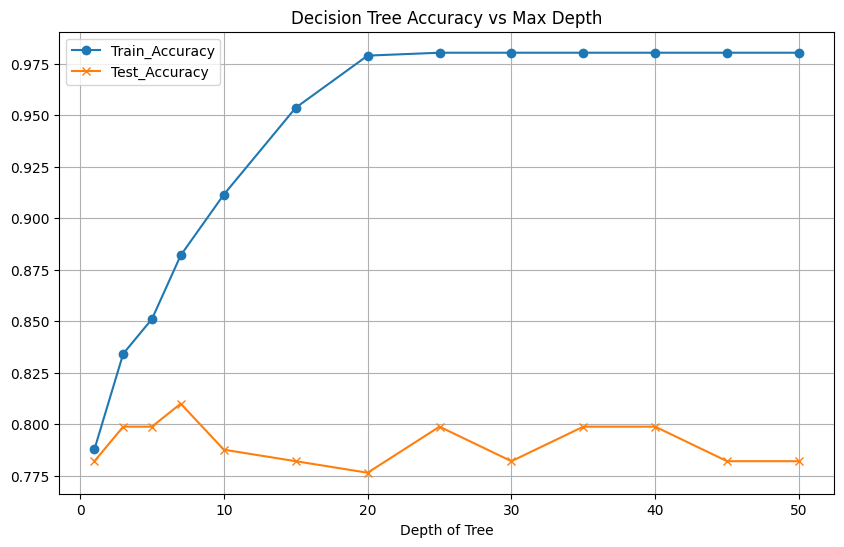

In [13]:
plt.figure(figsize=(10,6))
plt.plot(dep, train_acc, marker = 'o', label="Train_Accuracy")
plt.plot(dep, test_acc, marker = 'x', label="Test_Accuracy")
plt.grid()
plt.title('Decision Tree Accuracy vs Max Depth')
plt.xlabel("Depth of Tree")
plt.legend()
plt.show()

- Optimal Depth: max_depth=3 or 5 (test accuracy 79.888%), balancing performance and generalization.
- Underfitting: max_depth=1 (low train/test accuracy: 78.792%/78.212%).
- Overfitting: max_depth≥15 (high train accuracy ~98%, declining test accuracy down to 77.654% at max_depth=50).
- Recommendation: Use max_depth=3 for simplicity and good generalization.

# ROC & AUC Analysis

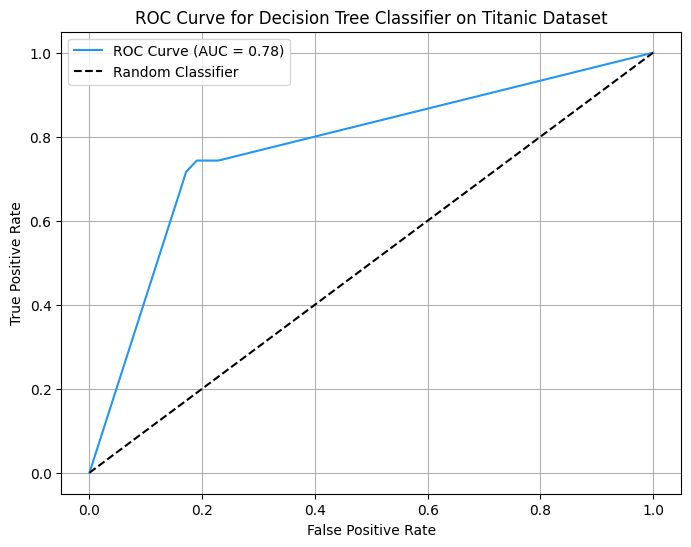

AUC: 0.78


In [14]:
from sklearn.metrics import roc_curve, roc_auc_score

# Get predicted probabilities for the positive class (survived=1)
y_proba = dt.predict_proba(X_test)[:,1]

fpr, tpr, _ = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})', color='#2196F3')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Decision Tree Classifier on Titanic Dataset')
plt.legend()
plt.grid(True)
plt.show()

# Print AUC
print(f"AUC: {auc:.2f}")

# With and without Cross-Validation

In [15]:
from sklearn.model_selection import cross_val_score, KFold

folds = KFold(n_splits=10, shuffle=True, random_state=42)
models = []
acc = []


lr = LogisticRegression()
models.append(lr)
dt = DecisionTreeClassifier()
models.append(dt)

for mod in models: 
    mod.fit(X_train, y_train)
    y_pred = mod.predict(X_test)
    acc.append(accuracy_score(y_pred, y_test))

print("Accuracies")
print(f"Logistic Regression : {acc[0]:.2f}, and Decision Tree : {acc[1]:.2f}")

Accuracies
Logistic Regression : 0.80, and Decision Tree : 0.79


In [16]:
f_acc = []
for mod in models: 
    score = cross_val_score(mod, X, Y, scoring='accuracy', cv=folds)
    print("Cross Validation of Model")
    for i, sc in enumerate(score, 1):
        print(f"Fold {i}: {sc*100:.2f}")
        f_acc.append(sc*100)


Cross Validation of Model
Fold 1: 84.44
Fold 2: 75.28
Fold 3: 82.02
Fold 4: 76.40
Fold 5: 78.65
Fold 6: 84.27
Fold 7: 78.65
Fold 8: 74.16
Fold 9: 71.91
Fold 10: 85.39
Cross Validation of Model
Fold 1: 78.89
Fold 2: 83.15
Fold 3: 79.78
Fold 4: 73.03
Fold 5: 80.90
Fold 6: 78.65
Fold 7: 73.03
Fold 8: 79.78
Fold 9: 75.28
Fold 10: 84.27


It is clear that Cross validation does increases Accuracy

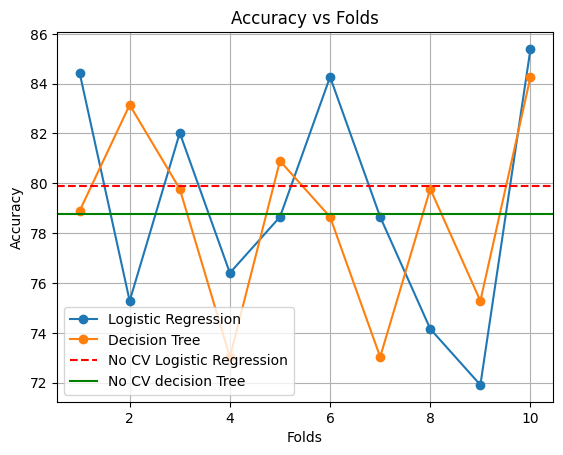

In [17]:
f = [col for col in range(1,11)]

plt.plot(f, f_acc[0:10], marker='o', label='Logistic Regression')
plt.plot(f, f_acc[10:20], marker='o', label='Decision Tree')
plt.axhline(y=(acc[0]*100), label='No CV Logistic Regression', linestyle='--', color='r')
plt.axhline(y=(acc[1]*100), label='No CV decision Tree', linestyle='-', color='g')
plt.xlabel('Folds')
plt.ylabel("Accuracy")
plt.title("Accuracy vs Folds")
plt.grid()
plt.legend()
plt.show()

# Cross-Validation to Random Forest Classifier

In [18]:
from sklearn.ensemble import RandomForestClassifier

folds = KFold(n_splits=20, shuffle=True, random_state=53)

rf = RandomForestClassifier()
score = cross_val_score(rf, X, Y, cv=folds, scoring='accuracy')
f = [col for col in range(1,21)]

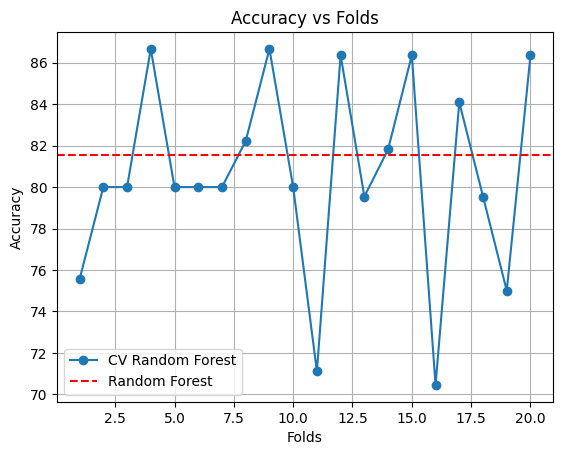

In [19]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_predd = rf.predict(X_test)

plt.plot(f, score*100, marker='o', label='CV Random Forest')
plt.axhline((accuracy_score(y_predd, y_test) * 100), linestyle='--', label='Random Forest', color='r')
plt.xlabel('Folds')
plt.ylabel("Accuracy")
plt.title("Accuracy vs Folds")
plt.grid()
plt.legend()
plt.show()

# Other Metrics on RF

In [20]:
# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_predd)
recall = recall_score(y_test, y_predd)
f1 = f1_score(y_test, y_predd)

# Print results
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Precision: 0.79
Recall: 0.76
F1-Score: 0.77


- Precision (0.79): 79% of predicted survivors were actually survivors, indicating good reliability in positive predictions.
- Recall (0.74): 74% of actual survivors were correctly identified, showing moderate sensitivity to detecting survivors.
- F1-Score (0.76): Balances precision and recall, suggesting decent performance on the imbalanced Titanic dataset.
  
Trade-offs and Importance: These metrics highlight the model’s ability to balance false positives and false negatives, crucial for evaluating performance beyond accuracy in life-critical scenarios like survival prediction.